PyTorch GRU based stock prediction model. Inspired by this Medium [article](https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f) and this Kaggle [post](https://www.kaggle.com/taronzakaryan/stock-prediction-lstm-using-pytorch) on stock prediction. I wanted to benchmark how a GRU performed compared to the LSTMs used previously.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls "/content/gdrive/My Drive/GRU Stock Prediction/datasets"

PATH = '/content/gdrive/My Drive/GRU Stock Prediction/datasets/{symbol}'

Mounted at /content/gdrive
TSLA.csv


In [35]:
import os
import math
import random
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

Data shape: (1306, 1)
                 TSLA
2015-07-10  51.830002
2015-07-13  52.431999
2015-07-14  53.130001
2015-07-15  52.627998
2015-07-16  53.335999


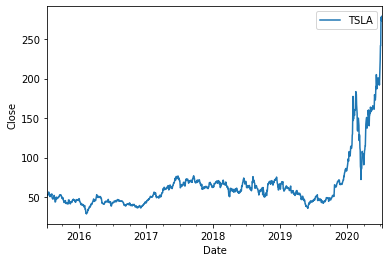

In [3]:
def fetch_df(symbols, dates, scale=True):
    '''
    csv loader and scaler for dataset
    source: https://blog.floydhub.com/gru-with-pytorch/
    '''
    df = pd.DataFrame(index=dates)
    label_scalers = {}

    for symbol in symbols:
        df_temp = pd.read_csv(PATH.format(symbol=symbol+'.csv'), index_col='Date', parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
        if scale:
            # normalize input features
            sc = MinMaxScaler()
            label_sc = MinMaxScaler()
            data = sc.fit_transform(df_temp.values) 

            # store scaling for the labels when evaluating output
            label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
            label_scalers[symbol] = label_sc

    return df

symbols = ['TSLA']
dates = pd.date_range(start='2015-07-10',end='2020-07-10',freq='B')
df = fetch_df(symbols, dates)

print('Data shape:',df.shape)
print(df.head(5))

df = df.fillna(method='ffill')
df.interpolate().plot()
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

Split into test and training sets. 

In [68]:
# def min_max_scalar(x, feature_range=(0,1), dim=0):
#     '''
#     replicates behaviour of sklearn.preprocessing.MinMaxScalar
#     '''
#     x_std = (x - x.min(dim, keepdim=True).values) / (x.max(dim, keepdim=True).values - x.min(dim, keepdim=True).values)
#     x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
#     return x_scaled, x_std


def symbol_loader(df, symbol, lookback=20, test_split=0.2, shuffle=False):
    '''
    convert df of symbol close prices to a tensor array with (n-lookback) sequences of `lookback`
    '''
    price = torch.tensor(df[symbol].values)
    T = len(price) - lookback
    data = torch.zeros(T, lookback)

    for i in range(T):
        data[i,:] = price[i:i+lookback]
    
    print(data.shape)
    data = data.view(T, 1, -1)
    print(data.shape)

    test_size = int(test_split * T)
    train_size = T - test_size

    idx = list(range(T))

    if shuffle:
        random.shuffle(idx)

    x_train = data[idx[:train_size], :, :-1]
    y_train = data[idx[:train_size], 0, -1]
    x_test = data[idx[train_size:test_size+train_size], :, :-1]
    y_test = data[idx[train_size:test_size+train_size], 0, -1]

    return x_train, y_train, x_test, y_test, idx


lookback = 20
x_train, y_train, x_test, y_test, idx = symbol_loader(df, 'TSLA', lookback)

print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

torch.Size([1286, 20])
torch.Size([1286, 1, 20])
x_train.shape: torch.Size([1029, 1, 19])
y_train.shape: torch.Size([1029])
x_test.shape: torch.Size([257, 1, 19])
y_test.shape: torch.Size([257])


In [69]:
# print(x_train)
# print(x_train.min(0, keepdim=True).values)
# print(x_train - x_train.min(0, keepdim=True).values)

# sc = MinMaxScaler()
# lsc = MinMaxScaler()
# data = sc.fit_transform(df.values)
# lsc.fit(df.iloc[:,0].values.reshape(-1,1))
# print(lsc.inverse_transform(data))

In [70]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, drop=0.2, bi=False):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # n_layers stacked GRU cells - dropout applied except last layer
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop, bidirectional=bi)
        # ReLU activation
        self.relu = nn.ReLU()
        # fully connected final layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden


    def forward(self, x, h):
        x, h = self.gru(x,h)
        x = self.fc(self.relu(x[:,-1]))
        return x, h

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, drop=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)
    

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device), 
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden


    def forward(self, x, h):
        x, h = self.lstm(x,h)
        x = self.fc(self.relu(x[:,-1]))
        return x, h


In [71]:
def model_summary(model):
    print('Model Summary\n')
    print('Layer Name'+'\t'*7+'Number of Parameters')
    print('='*100)
    model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
    layer_name = [child for child in model.children()]
    j = 0
    total_params = 0
    print('\t'*10)
    for i in layer_name:
      print()
      param = 0
      try:
        bias = (i.bias is not None)
      except:
        bias = False  
      if not bias:
        param = model_parameters[j].numel()+model_parameters[j+1].numel()
        j = j + 2
      else:
        param = model_parameters[j].numel()
        j = j + 1
      print(str(i)+'\t'*3+str(param))
      total_params+=param
    print('='*100)
    print(f'Total Params:{total_params}')


In [72]:
'''
Set parameters, initialize dataloader
'''
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 8
epochs = 4
lr = 0.0001

train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)


In [73]:
def train(trainloader, lr, hidden_dim=128, epochs=5, n_layers=2, model='GRU'):
    input_dim = next(iter(train_loader))[0].shape[1]
    output_dim = 1
    
    '''instantiate models'''
    if model == 'GRU':
        net = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        net = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model_summary(net)
    net.to(device)
    net.train()

    '''criterion and optimizer'''
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    '''train for specified epochs'''
    print('Starting training...')
    start = time.time()

    losses = []

    for epoch in range(epochs):
        h = net.init_hidden(batch_size)
        running_loss = 0.
        for i, data in enumerate(trainloader, 0):
            optimizer.zero_grad()
            net.zero_grad()

            input, label = data

            if model == 'GRU':
                h = h.data
            else:
                h = tuple([h_.data for h_ in h])
          
            out, h = net(input.to(device).float(), h)
            loss = criterion(out, label.to(device).float())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 20 == 0:
                print('Epoch: {} \tStep: {}/{} \tAverage loss: {}'.format(epoch+1, i, len(trainloader), running_loss/i))
                losses.append(running_loss)

    print('Training complete... Final Loss: {}\nSeconds elapsed:{}'.format(loss, time.time()-start))
    return net


train(train_loader, lr)



Model Summary

Layer Name							Number of Parameters
										

GRU(1, 128, batch_first=True, dropout=0.2)			384

ReLU()			49536

Linear(in_features=128, out_features=2, bias=True)			384
Total Params:50304
Starting training...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RuntimeError: ignored

1609286017.8016949